#  Прогнозирование уровня средней заработной платы в России

In [245]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных и визуализация

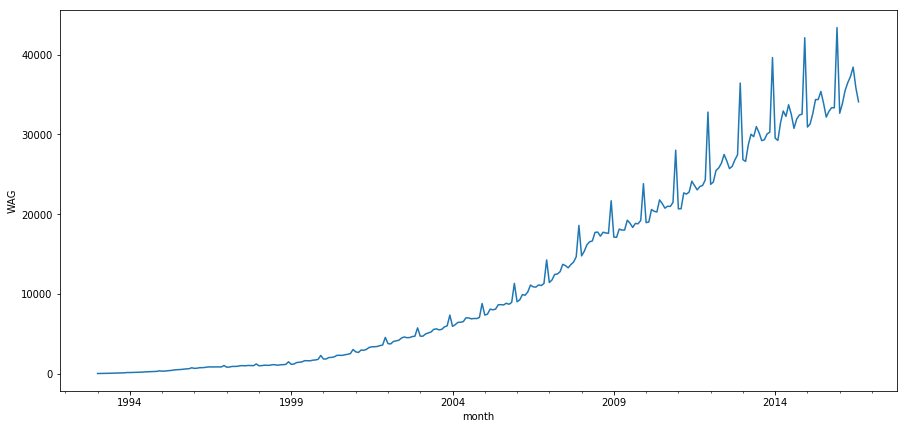

In [246]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('WAG')
pylab.show()

Посмотрим на STL-декомпозицию:

Критерия Дики-Фуллера pvalue: 0.991850


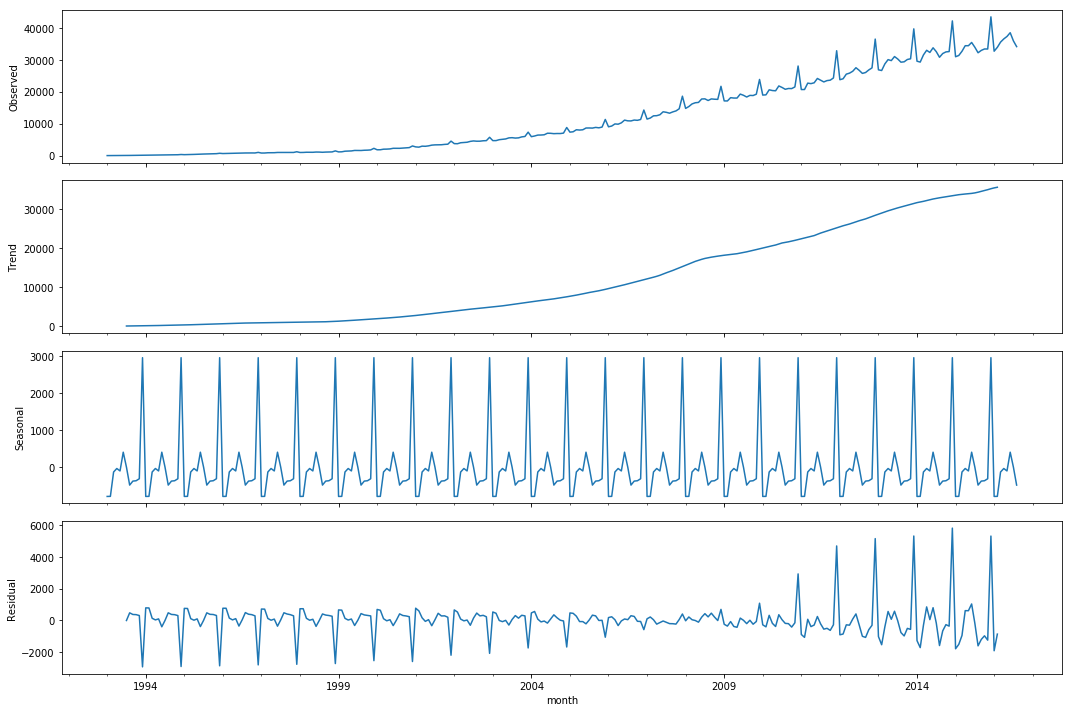

In [247]:
print("Критерия Дики-Фуллера pvalue: %f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
plt.show()

Ряд явно нестационарен

## Избавляемся от нестационарности

### Стабилизация дисперсии

Видно, что ближе к концу ряда дисперсия увеличивается. Так что попробуем ее стабилизировать.

Критерия Дики-Фуллера pvalue: 0.696899


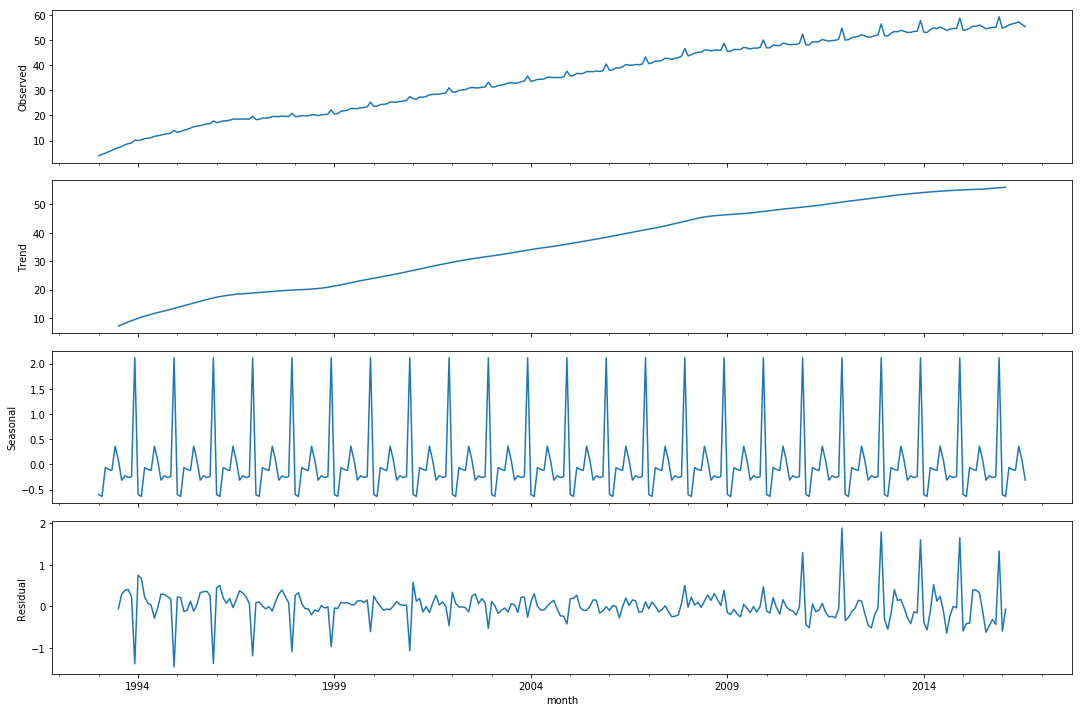

In [248]:
data['stab_var'], lmbda = stats.boxcox(data.WAG_C_M)
print("Критерия Дики-Фуллера pvalue: %f" % sm.tsa.stattools.adfuller(data.stab_var)[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.stab_var).plot()
plt.show()

Ряд все еще нестационарен

### Дифференцирование

In [249]:
first_value_num = 12

Критерий Дики-Фуллера: p=0.014697


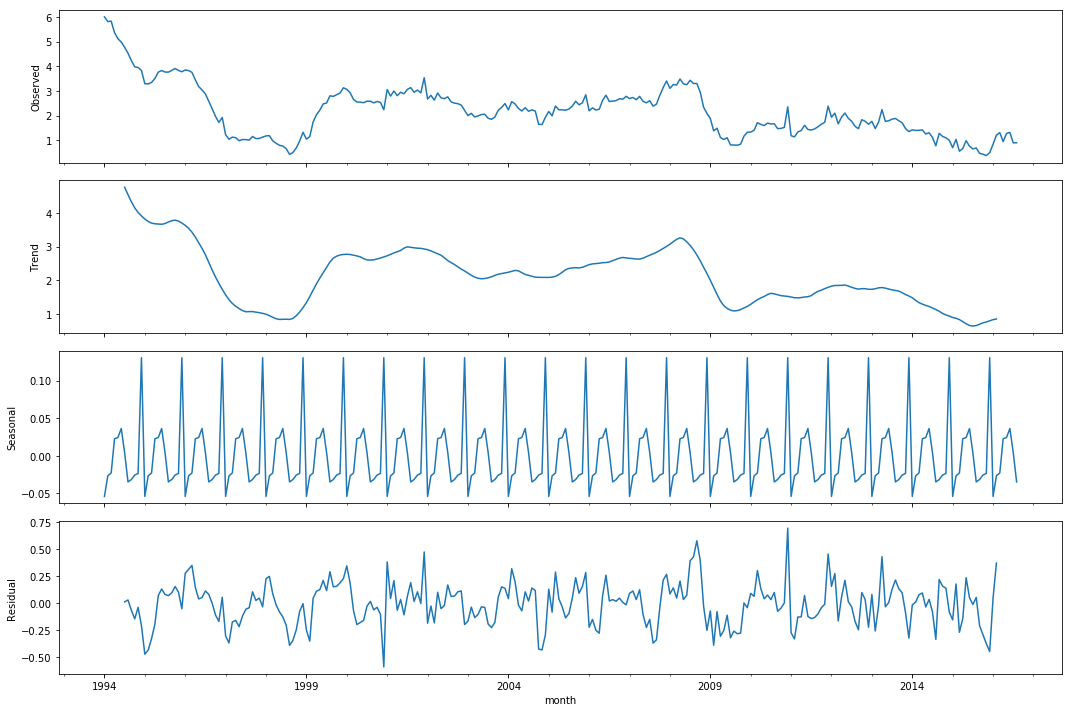

In [250]:
data['season'] = data.stab_var - data.stab_var.shift(12)    
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.season[first_value_num:])[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.season[first_value_num:]).plot()   
plt.show()

In [251]:
first_value_num = 13

Критерий Дики-Фуллера: p=0.000000


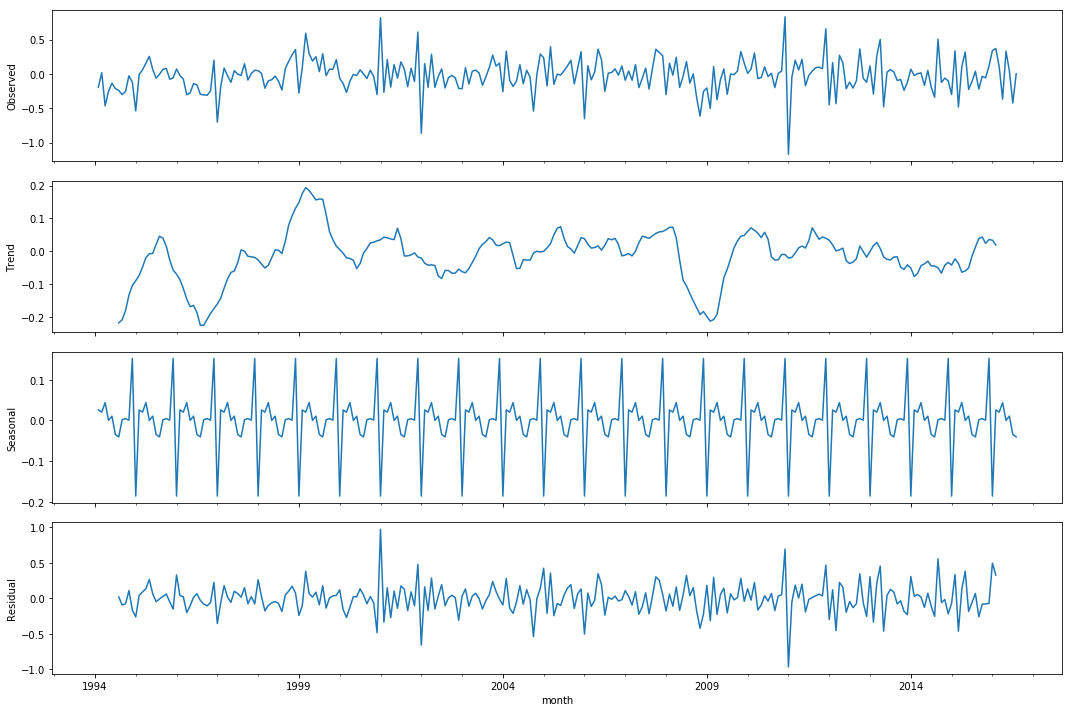

In [252]:
data['diff2'] = data.season - data.season.shift(1)    
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.diff2[first_value_num:])[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.diff2[first_value_num:]).plot()   
plt.show()

Гипотеза о нестационарности ряда отвергается на уровне значимости 0.05. По графикам также не видно каких-либо явных признаков нестационарности.

## Подбор гиперпараметров

Построим графики автокорреляции и частичной автокорреляции для выбора $q, Q, p$ и $P$.

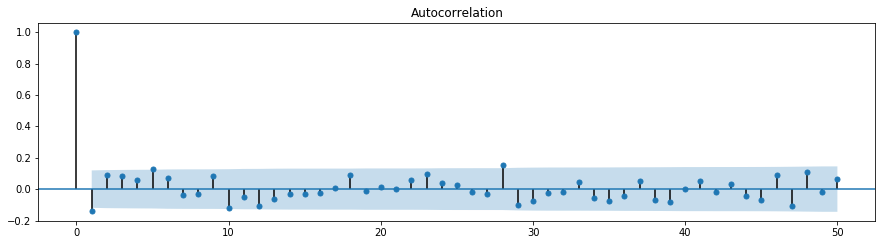

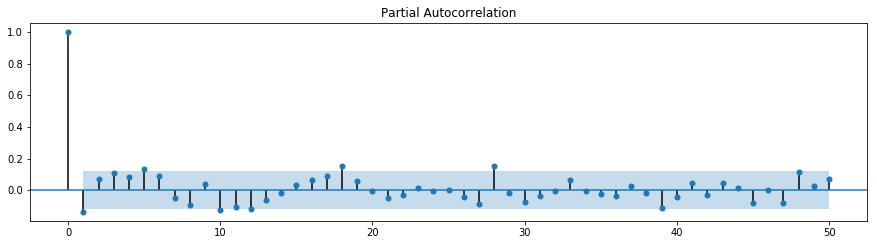

In [254]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.diff2[first_value_num:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.diff2[first_value_num:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Возьмем в качетсве начальных: 

$q=10, Q=0, p=1, P=0$.

In [265]:
q = range(5)
Q = [0]
p = range(5)
P = [0]
d = 1
D = 1

In [266]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

25

## Обучение модели

In [267]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.stab_var, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 4, 0, 0))
CPU times: user 6.22 s, sys: 285 ms, total: 6.5 s
Wall time: 6.73 s


In [268]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
7,"(1, 4, 0, 0)",-6.338074
6,"(1, 3, 0, 0)",-5.363684
10,"(2, 4, 0, 0)",-4.525603
12,"(3, 1, 0, 0)",-1.392773
16,"(4, 1, 0, 0)",-0.332498


In [269]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           stab_var   No. Observations:                  284
Model:             SARIMAX(1, 1, 4)x(0, 1, 0, 12)   Log Likelihood                   9.169
Date:                            Sat, 06 Jan 2018   AIC                             -6.338
Time:                                    13:33:07   BIC                             15.556
Sample:                                01-01-1993   HQIC                             2.440
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6974      0.161      4.331      0.000       0.382       1.013
ma.L1         -0.8670      0.169     -5.122      0.000      -1.199      -0.535
ma.L2          0.1218      0.095      1.283      0.199      -0.064       0.308
ma.L3          0.1048      0.086      1.218      0.223      -0.064       0.273
ma.L4          0.1160      0.087      1.326      0.185      -0.055       0.287
sigma2         0.0546      0.004     14.960      0.000       0.047       0.062
===================================================================================
Ljung-Box (Q):                       50.83   Jarque-Bera (JB):                47.60
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Критерий Стьюдента: p=0.368601
Критерий Дики-Фуллера: p=0.000000


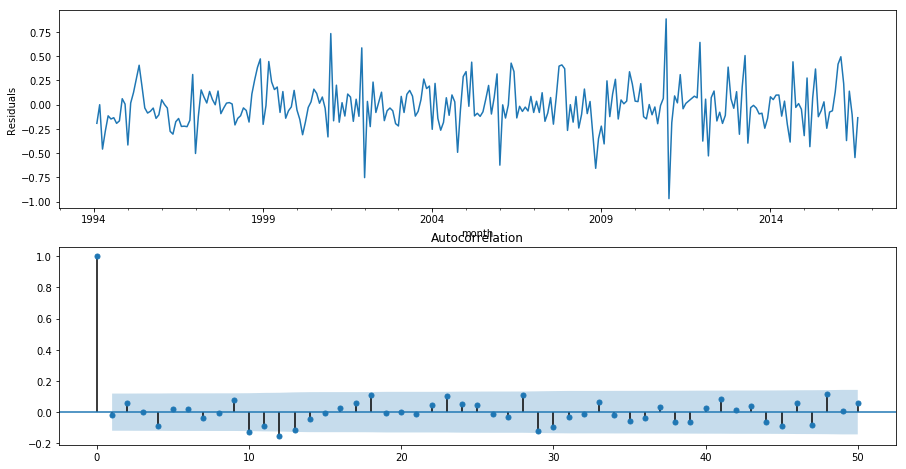

In [270]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[first_value_num:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[first_value_num:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[first_value_num:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[first_value_num:])[1])

Остатки неавтокоррелированны (критерий Люнга-Бокса и коррелограмма), стационарны (критерий Дики-Фуллера и график) и несмещены (критерий Стьюдента)

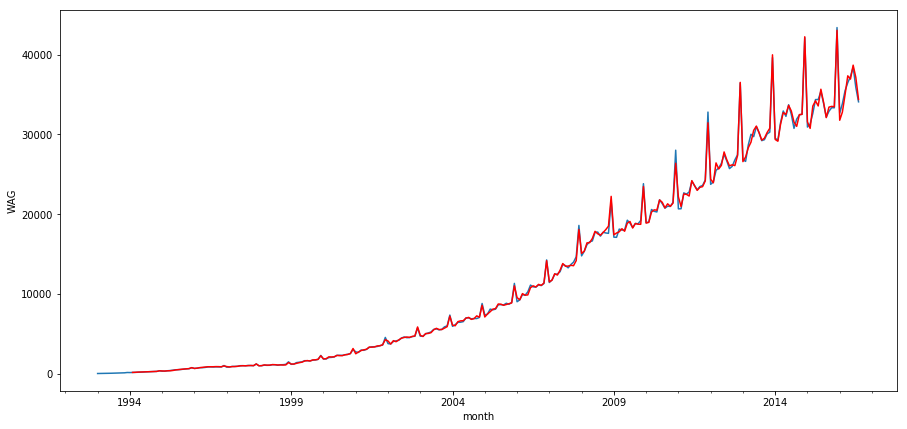

Timestamp('2016-08-01 00:00:00')

In [273]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[first_value_num:].plot(color='r')
plt.ylabel('WAG')
pylab.show()
data.index[data.shape[0] - 1]

## Построение прогноза

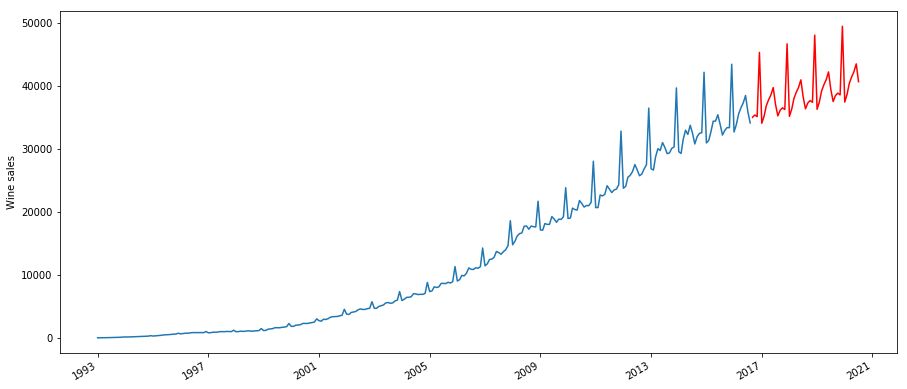

In [283]:
predicts = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= predicts.columns)
predicts = pd.concat([predicts, future])
predicts['forecast'] = invboxcox(best_model.predict(start=284, end=284 + 48), lmbda)

plt.figure(figsize(15,7))
predicts.WAG_C_M.plot()
predicts.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Вышел достаточно неплохой прогноз, кажется, что даже тренд учтен.